In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/PCE')

Mounted at /content/drive


In [11]:
!pip install casadi chaospy

Defaulting to user installation because normal site-packages is not writeable


In [12]:
import casadi as ca
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [14]:
from wind_models import originalWindModel
from integrators import rk4
from multiple_planes_solution_advanced import solve_multiple_planes_ocp_advanced

In [15]:
np.random.seed(1)
# k_values = np.random.normal(1, 0.25, 6)
k_values = [0.16893564, 0.52770603, 0.84582335, 1.15417665, 1.47229397, 1.83106436]

In [16]:
res = solve_multiple_planes_ocp_advanced(k_values, verbose=False)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 256.00us (  6.40us) 254.58us (  6.36us)        40
       nlp_g  | 203.38ms (  5.08ms) 203.40ms (  5.08ms)        40
  nlp_grad_f  | 504.00us ( 12.29us) 487.28us ( 11.88us)        41
   nlp_jac_g  |   1.41 s ( 34.51ms)   1.41 s ( 34.49ms)        41
       total  |   4.42 s (  4.42 s)   4.42 s (  4.42 s)         1


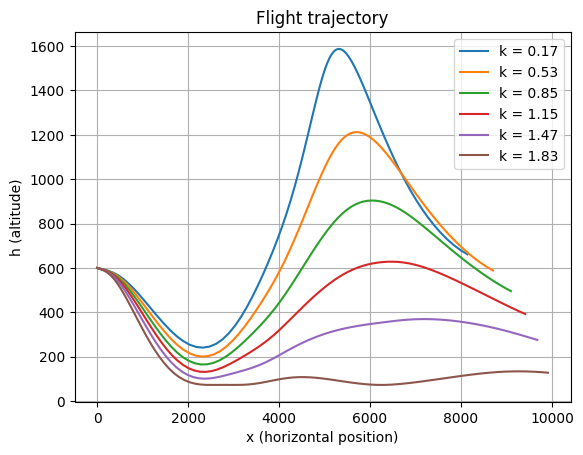

In [17]:
# Plot res
import matplotlib.pyplot as plt

plt.figure()
for i, k in enumerate(k_values):
    plt.plot(res["x"][i], res["h"][i], label=f"k = {k:.2f}")

plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory")
plt.legend()
plt.grid()
plt.show()

In [53]:
from multiple_planes_solution_advanced import aircraft_ode
from integrators import rk4

def reconstruct_trajectory(u_opt, k_value):
    N = 80

    x = np.zeros(N + 1)
    h = np.zeros(N + 1)
    v = np.zeros(N + 1)
    gamma = np.zeros(N + 1)
    alpha = np.zeros(N + 1)
    t_values = np.zeros(N + 1)
  
    x[0] = 0
    h[0] = 600
    v[0] = 239.7
    gamma[0] = -0.03925
    alpha[0] = 0.1283

    T  = 40
    dt = T / N

    f = aircraft_ode(originalWindModel, k_value)
    for i in range(0, N):
        Yk = [x[i], h[i], v[i], gamma[i], alpha[i]]
        y = rk4(
            f,
            Yk,
            u_opt[i],
            dt * i,
            dt
        )
        x[i + 1] = y[0]
        h[i + 1] = y[1]
        v[i + 1] = y[2]
        gamma[i + 1] = y[3]
        alpha[i + 1] = y[4]

    sol = {
        "x" : x,
        "h" : h,
        "V" : v,
        'gamma' : gamma,
        "alpha" : alpha,
        "u" : u_opt,
        "w" : 0.5,
        "t" : np.linspace(0, T, N + 1),
    }
    return sol

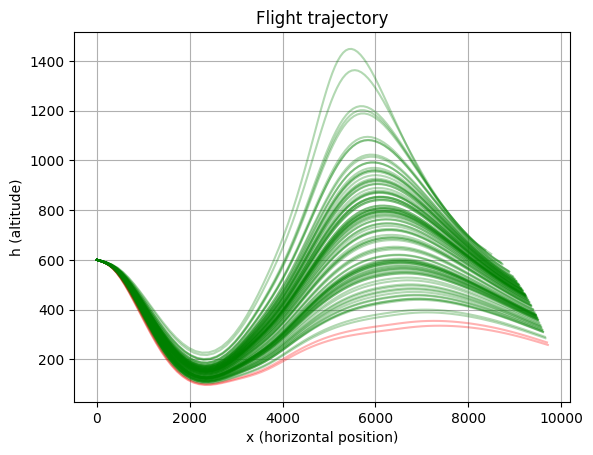

In [54]:
u_opt = res["u"]

for k in np.random.normal(1, 0.25, 100):
    sol = reconstruct_trajectory(u_opt, k)
    x_traj, h_traj = sol["x"], sol["h"]
    if min(h_traj) < 100:
        plt.plot(x_traj, h_traj, color='red', alpha = 0.3, label=f"k={k:.2f}")
    else:
        plt.plot(x_traj, h_traj, color='green', alpha = 0.3, label=f"k={k:.2f}")

plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory")
plt.grid()
# plt.legend()
plt.show()

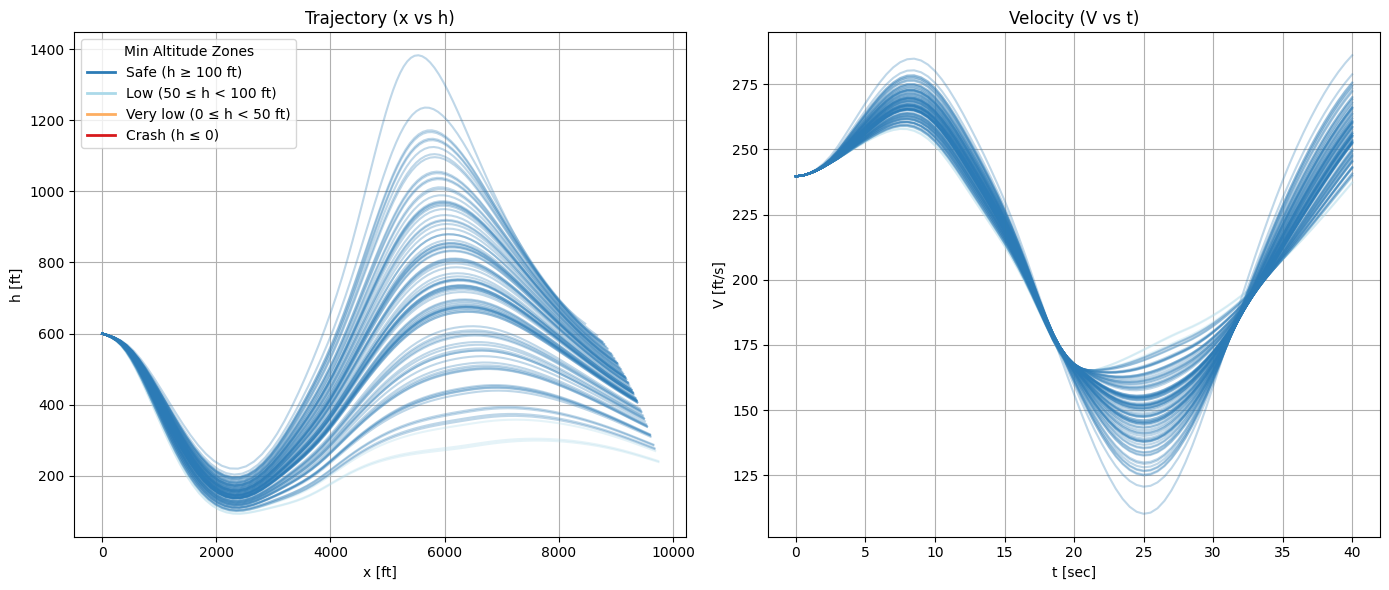

P(Under 100) = 0.030000
P(Under 50) = 0.000000
P(Under 0) = 0.000000


In [58]:
colors = {
    "safe": "#2c7bb6",      # Dark Blue
    "low": "#abd9e9",       # Light Blue
    "very_low": "#fdae61",  # Orange
    "crash": "#d7191c"      # Red
}

# Physical constants
m = 4662
g = 32.172
delta = 0.03491
A0 = 0.4456e5
A1 = -0.2398e2
A2 = 0.1442e-1
rho = 0.2203e-2
S = 0.1560e4
beta0 = 0.4
beta_dot0 = 0.2
sigma = 3
B0 = 0.1552
B1 = 0.12369
B2 = 2.4203
C0 = 0.7125
C1 = 6.0877
C2 = -9.0277
alpha_star = 0.20944
a = 6e-8
b = -4e-11
c = -np.log(25/30.6)*1e-12
d = -8.02881e-8
e = 6.28083e-11
h_star = 1000
eps = 1e-6

# Wind model functions
def Smooth(x_, x0, x1):
    t = (x_ - x0) / (x1 - x0 + eps)
    return ca.if_else(x_ < x0, 0,
           ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

def A_piecewise(x_):
    A1v = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
    A4 = 50
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*A1v + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4
    return ca.if_else(x_ <= 500, B12,
           ca.if_else(x_ <= 4100, B23,
           ca.if_else(x_ <= 4600, B34, A4)))

def B_piecewise(x_):
    B1v = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
    B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
    B4 = 0
    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)
    B12 = (1 - s1)*B1v + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4
    return ca.if_else(x_ <= 500, B12,
           ca.if_else(x_ <= 4100, B23,
           ca.if_else(x_ <= 4600, B34, B4)))

def wind_x(x_, k_):
    return k_ * A_piecewise(x_)

def wind_h(x_, h_, k_):
    h_safe = ca.fmax(h_, 10.0)
    return k_ * h_safe / h_star * B_piecewise(x_)

def prepare_numpy_wind_functions(k_value):
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])
    Wx_fun = ca.Function("Wx_fun", [x_sym], [Wx_expr])
    Wh_fun = ca.Function("Wh_fun", [x_sym, h_sym], [Wh_expr])
    return {
        "Wx": Wx_fun,
        "Wh": Wh_fun,
        "dWx_dx": dWx_dx_fun,
        "dWh_dx": dWh_dx_fun,
        "dWh_dh": dWh_dh_fun
    }

def get_numpy_aircraft_ode(k_value):
    wind_funcs = prepare_numpy_wind_functions(k_value)
    def aircraft_ode_np(X, u, t):
        x_, h_, V_, gamma_, alpha_ = X
        T = (beta0 + beta_dot0 * t if t < sigma else 1.0) * (A0 + A1 * V_ + A2 * V_**2)
        D = 0.5 * (B0 + B1 * alpha_ + B2 * alpha_**2) * rho * S * V_**2
        CL = C0 + C1 * alpha_ if alpha_ <= alpha_star else C0 + C1 * alpha_ + C2 * (alpha_ - alpha_star)**2
        L = 0.5 * rho * S * CL * V_**2
        Wx = float(wind_funcs["Wx"](x_))
        Wh = float(wind_funcs["Wh"](x_, h_))
        dWx_dx = float(wind_funcs["dWx_dx"](x_))
        dWh_dx = float(wind_funcs["dWh_dx"](x_, h_))
        dWh_dh = float(wind_funcs["dWh_dh"](x_, h_))
        V_safe = max(V_, 1e-3)
        x_dot = V_ * np.cos(gamma_) + Wx
        h_dot = V_ * np.sin(gamma_) + Wh
        Wx_dot = dWx_dx * x_dot
        Wh_dot = dWh_dx * x_dot + dWh_dh * h_dot
        V_dot = T / m * np.cos(alpha_ + delta) - D / m - g * np.sin(gamma_) - (Wx_dot * np.cos(gamma_) + Wh_dot * np.sin(gamma_))
        gamma_dot = T / (m * V_safe) * np.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * np.cos(gamma_) + (1 / V_safe) * (Wx_dot * np.sin(gamma_) - Wh_dot * np.cos(gamma_))
        alpha_dot = u
        return np.array([x_dot, h_dot, V_dot, gamma_dot, alpha_dot])
    return aircraft_ode_np

def rk4_step_np(f, xk, uk, tk, dt):
    k1 = f(xk, uk, tk)
    k2 = f(xk + dt/2 * k1, uk, tk + dt/2)
    k3 = f(xk + dt/2 * k2, uk, tk + dt/2)
    k4 = f(xk + dt * k3, uk, tk + dt)
    return xk + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

# Set simulation parameters
np.random.seed(0)
k_values = np.random.normal(1, 0.25, 100)
tf = 40
N = 80
dt = 40 / 80
x0 = 0
h0 = 600
V0 = 239.7
gamma0 = -0.03925
alpha0 = 0.1283

under_0, under_50, under_100 = 0, 0, 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for k in k_values:
    traj = reconstruct_trajectory(u_opt, k)

    if min(traj["h"]) < 1e-6:
        under_0 += 1
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["crash"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["crash"])
    elif min(traj["h"]) < 50:
        under_50 += 1
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["very_low"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["very_low"])
    elif min(traj["h"]) < 100:
        under_100 += 1
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["low"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["low"])
    else:
        ax1.plot(traj["x"], traj["h"], alpha=0.3, color=colors["safe"])
        ax2.plot(traj["t"], traj["V"], alpha=0.3, color=colors["safe"])

ax1.set_xlabel("x [ft]")
ax1.set_ylabel("h [ft]")
ax1.set_title("Trajectory (x vs h)")
ax1.grid(True)
legend_elements = [
    Line2D([0], [0], color=colors["safe"],      lw=2, label='Safe (h ≥ 100 ft)'),
    Line2D([0], [0], color=colors["low"],       lw=2, label='Low (50 ≤ h < 100 ft)'),
    Line2D([0], [0], color=colors["very_low"],  lw=2, label='Very low (0 ≤ h < 50 ft)'),
    Line2D([0], [0], color=colors["crash"],     lw=2, label='Crash (h ≤ 0)')
]
ax1.legend(handles=legend_elements, loc='upper left', title="Min Altitude Zones")

ax2.set_xlabel("t [sec]")
ax2.set_ylabel("V [ft/s]")
ax2.set_title("Velocity (V vs t)")
ax2.grid(True)
# ax2.legend()

plt.tight_layout()
plt.show()

print(f"P(Under 100) = {(under_100+under_50+under_0)/len(k_values):.6f}")
print(f"P(Under 50) = {(under_50+under_0)/len(k_values):.6f}")
print(f"P(Under 0) = {under_0/len(k_values):.6f}")

$ k(1 + \sigma), \sigma \sim N(0,1)$